In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install opencv-python
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
!pip install tdqm





  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=26d57397eaf2190ac826b3652d8f744bc52d02ad6e24ffb56634cfaff4e67e93
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
from glob import glob
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
""" U-net Architecture """



def conv_block(inputs, num_filters):

    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def encoder_block(inputs, num_filters):
    """
    The encoder block of U-net
    :param inputs: The input
    :param num_filters:
    :return: x - output of the convolutional block and to be used for concatenation
             p - ouput of the maxpool2D block
    """

    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p


def decoder_block(inputs, skip_features, num_filters):
    """
   The decoder block of the U-net
   :param inputs: The input
   :param skip_features:
   :param num_filters:
   :return:
    """
    x = Conv2DTranspose(num_filters, 2, strides = 2, padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    input = Input(input_shape)

    # Encoder block
    s1, p1 = encoder_block(input, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Base
    b1 = conv_block(p4, 1024)

    # Decoder Block
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, kernel_size = 1, padding="same", activation = "sigmoid")(d4)

    model = Model(input, outputs, name = "UNET")
    return model




In [ ]:

""" Evaluation Metrics """

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)




In [ ]:
" Train Model "

# Global Value
height = 256
width = 256


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_dataset(path, split):
  images = sorted(glob(os.path.join(path, "images", "*.png")))
  masks = sorted(glob(os.path.join(path, "masks", "*.png")))

  split_size = int(len(images) * split)


  train_x, val_x = train_test_split(images, test_size = split_size, random_state = 42)
  train_y, val_y = train_test_split(masks, test_size = split_size, random_state = 42)

  train_x, test_x = train_test_split(train_x, test_size = split_size, random_state = 42)
  train_y, test_y = train_test_split(train_y, test_size = split_size, random_state = 42)

  return (train_x, train_y), (val_x, val_y), (test_x, test_y)

def read_img(path, width = 256, height = 256):
  path = path.decode()
  image = cv.imread(path, cv.IMREAD_COLOR)
  image = cv.resize(image, (width, height))
  # Normalize the image
  image = image / 255.0
  image = image.astype(np.float32)

  return image

def read_mask(path, width = 256, height = 256):
  path = path.decode()
  mask = cv.imread(path, cv.IMREAD_GRAYSCALE)
  mask = cv.resize(mask, (width, height))
  # Normalize the mask
  mask = mask / 255.0
  mask = mask.astype(np.float32)
  mask = np.expand_dims(mask, axis = -1)

  return mask


def tf_parse(x, y):

  def _parse(x, y):
    image = read_img(x)
    mask = read_mask(y)
    return image, mask
  image, mask = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  image.set_shape([height, width, 3])
  mask.set_shape([height, width, 1])
  return image, mask


def tf_dataset(img_list, mask_list, batch = 2):
  dataset = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(10)
  return dataset

def save_result(img, mask, y_pred, save_img_path):

  mask = np.expand_dims(mask, axis = -1)
  mask = np.concatenate([mask, mask, mask], axis = -1)

  y_pred = np.expand_dims(y_pred, axis = -1)
  y_pred = np.concatenate([y_pred, y_pred, y_pred], axis = -1)
  y_pred = y_pred * 255

  line = np.ones((256, 10, 3)) * 255

  concat_images = np.concatenate([img, line, mask, line, y_pred], axis = 1)
  cv.imwrite(save_img_path, concat_images)



In [ ]:

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing file """
create_dir("drive/MyDrive/Brain_Tumor_Dataset/files")

""" Hyper parameters: """
batch_size = 16
lr = 1e-4
num_epochs = 50

model_path = os.path.join("drive/MyDrive/Brain_Tumor_Dataset/files", "model.h5")
csv_path = os.path.join("drive/MyDrive/Brain_Tumor_Dataset/files", "log.csv")


""" Dataset """
path = "drive/MyDrive/Brain_Tumor_Dataset/Dataset"
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_dataset(path, 0.2)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Validation: {len(val_x)} - {len(val_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(val_x, val_y, batch = batch_size)


Train: 1840 - 1840
Validation: 612 - 612
Test: 612 - 612


In [ ]:

model = build_unet((256, 256, 3))
model.compile(loss = dice_loss, optimizer = Adam(lr), metrics = [dice_coef])

history = [
  ModelCheckpoint(model_path, verbose = 1, save_best_only = True),
  ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 1e-7, verbose = 1),
  CSVLogger(csv_path),
  EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = False)
]

model.fit(
    train_dataset,
    epochs = num_epochs,
    validation_data = valid_dataset,
    callbacks = history
)

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.8624 - dice_coef: 0.1376
Epoch 1: val_loss improved from inf to 0.96757, saving model to drive/MyDrive/Brain_Tumor_Dataset/files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 95s 734ms/step - loss: 0.8624 - dice_coef: 0.1376 - val_loss: 0.9676 - val_dice_coef: 0.0324 - lr: 1.0000e-04
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 0.7490 - dice_coef: 0.2510
Epoch 2: val_loss improved from 0.96757 to 0.95453, saving model to drive/MyDrive/Brain_Tumor_Dataset/files/model.h5
115/115 [==============================] - 76s 650ms/step - loss: 0.7490 - dice_coef: 0.2510 - val_loss: 0.9545 - val_dice_coef: 0.0451 - lr: 1.0000e-04
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.6762 - dice_coef: 0.3238
Epoch 3: val_loss improved from 0.95453 to 0.94443, saving model to drive/MyDrive/Brain_Tumor_Dataset/files/model.h5
115/115 [==============================] - 68s 589ms/step - loss: 0.6762 - dice_coef: 0.3238 - val_loss: 0.9444 - val_dice_coef: 0.0557 - lr: 1.0000e-04
Epoch 4/50
115/115 [==============================] - ETA: 0s - loss: 0.5957 - dice_coef: 0.4043
Epoch 4: val_los

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm


""" Directory for storing files """
create_dir("drive/MyDrive/Brain_Tumor_Dataset/results")

""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
  model = tf.keras.models.load_model(os.path.join("drive/MyDrive/Brain_Tumor_Dataset/files", "model.h5"))


""" Dataset """
path = "drive/MyDrive/Brain_Tumor_Dataset/Dataset"
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_dataset(path, 0.2)

""" Prediction and Evaluation """
SCORE = []

for img_path, mask_path in tqdm(zip(test_x, test_y), total = len(test_x)):
  # Extracting the name
  name = img_path.split("/")[-1]

  # Reading the image
  image = cv.imread(img_path, cv.IMREAD_COLOR)
  image = cv.resize(image, (256, 256))
  image_path = image / 255.0
  image_path = np.expand_dims(image_path, axis = 0)


  # Reading the mask
  mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
  mask = cv.resize(mask, (256, 256))

  # Make prediction
  y_pred = model.predict(image_path, verbose=0)[0]
  y_pred = np.squeeze(y_pred, axis = -1)
  y_pred = y_pred >= 0.5
  y_pred = y_pred.astype(np.int32)

  # Saving the prediction
  save_img_path = os.path.join("drive/MyDrive/Brain_Tumor_Dataset/results", name)
  save_result(image, mask, y_pred, save_img_path)

  """ Flatten the array """
  mask = mask/255.0
  mask = (mask > 0.5).astype(np.int32).flatten()
  y_pred = y_pred.flatten()

  break






  0%|          | 0/612 [00:00<?, ?it/s]


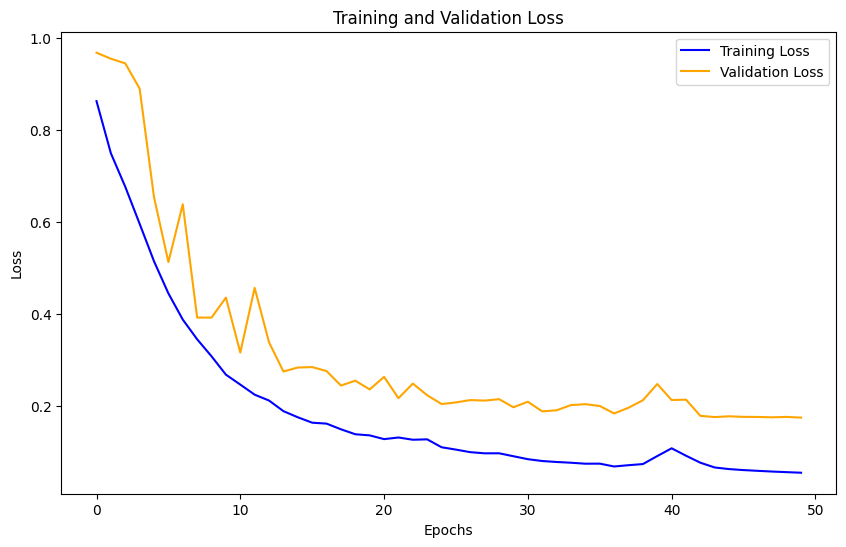

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('drive/MyDrive/Brain_Tumor_Dataset/files/log.csv')

# Extract relevant columns
epochs = df['epoch']
dice_coefficient = df['dice_coef']
loss = df['loss']
learning_rate = df['lr']
val_loss = df['val_loss']
val_dice_coefficient = df['val_dice_coef']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.show()